In [1]:
from __future__ import absolute_import, division, print_function

import sqlite3
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import utils.pandas_utils as pd_utils
import utils.units_utils as units
%load_ext autoreload
%autoreload 2

# Read in trial_lc.db into Pandas df
db = sqlite3.connect('trial_lc.db')

cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
cursor.close()

df = {}
for table in ['agn_lc', 'obs_metadata', 'sprinkled_objects',]:
    df[table] =  pd.read_sql_query("SELECT * from %s" %table, db)
    #df[table].to_csv('%s.csv' %table, index_label='index')

db.close()

# Read in truth.sqlite into Pandas df

truth = sqlite3.connect('truth.sqlite')
#truth_cursor = truth.cursor()
#truth_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(truth_cursor.fetchall())
#truth_cursor.close()
df['zpoint'] = pd.read_sql_query("SELECT * from 'zpoint'", truth)
truth.close()

#####################
# Preprocess zpoint #
#####################

# Unravel the dictionary inside the dictionary, of DRW parameters
df['zpoint'] = pd_utils.dict_of_dict_to_columns(df['zpoint'], dict_column='varParamStr', dict_key='p')

# Keep only the columns we care about
keep_truth_cols = ['uniqueId', 'galaxy_id', 'redshift', 'magNorm', 'agn_tau', 't0Delay']
keep_truth_cols += ['agn_sf%s' %b for b in 'ugrizy']
df['zpoint'] = df['zpoint'][keep_truth_cols]

# Keep only the rows with t0Delay values that are not NaN
df['zpoint'] = df['zpoint'][df['zpoint']['t0Delay'].notnull()]

# Rename some columns to avoid conflict later
df['zpoint'].rename(columns={'redshift': 'truth_redshift', 'galaxy_id': 'truth_galaxy_id'}, inplace=True)

#print(df['zpoint'].shape, df['agn_lc'].shape, df['obs_metadata'].shape)

#print(df['zpoint'].columns, df['agn_lc'].columns, df['obs_metadata'].columns)

#############
# Pre-check #
#############

# Check that the uniqueIds in sprinkled_objects are the same as those in agn_lc
assert pd_utils.a_relationship_b(a=df['sprinkled_objects'], b=df['agn_lc'], column='uniqueId', relationship='equal')

# Check that the uniqueIds in sprinkled_objects are same as those in zpoint
assert pd_utils.a_relationship_b(a=df['sprinkled_objects'], b=df['zpoint'], column='uniqueId', relationship='equal')

# Check that the obshistids in agn_lc are in obs_metadata
assert pd_utils.a_relationship_b(a=df['agn_lc'], b=df['obs_metadata'], column='obshistid', relationship='subset')

# Check if number of observations for each light curve is even
print(df['agn_lc'].groupby('uniqueId')['obshistid'].nunique())

# Check that the lens galaxies in sprinkled_objects are in zpoint
# Note: this will fail due to a bug in the zpoint table where the uniqueId-galaxy_id pairings are wrong.
#assert pd_utils.a_subset_of_b(a=df['sprinkled_objects'], b=df['zpoint'], 
#                              column_a='galaxy_id', column_b='truth_galaxy_id')

######################
# Remove unnecessary #
######################
# Warning: Original dataframes are altered.

# Remove obshistids that aren't in agn_lc, from obs_metadata
lc_obshistids = df['agn_lc']['obshistid'].unique().copy()
mask_obs = df['obs_metadata']['obshistid'].isin(lc_obshistids)
df['obs_metadata'] = df['obs_metadata'].loc[mask_obs]

# Total number of observed visits should equal the number of agn images times number of visits per agn image 
lc_uniqueIds = df['agn_lc']['uniqueId'].unique().copy()
assert df['agn_lc'].shape[0] == df['obs_metadata'].shape[0]*len(lc_uniqueIds)

# Merge agn_lc and sprinkled_objects
sprinkled_lc = pd.merge(df['agn_lc'], df['sprinkled_objects'], on='uniqueId')

# Merge this with zpoint
sprinkled_lc_withtruth = pd.merge(sprinkled_lc, df['zpoint'], on='uniqueId')

# Merge this with obs_metadata
sprinkled_lc_obs_withtruth = pd.merge(sprinkled_lc_withtruth, df['obs_metadata'], on='obshistid')

# Check shape
assert np.array_equal(sprinkled_lc_obs_withtruth.shape,
                      [len(lc_uniqueIds)*len(lc_obshistids),
                       df['agn_lc'].shape[1] + df['sprinkled_objects'].shape[1] + df['zpoint'].shape[1] + df['obs_metadata'].shape[1] - 3])

[(u'agn_lc',), (u'sne_lc',), (u'obs_metadata',), (u'sprinkled_objects',)]
uniqueId
338704312844405    1282
338704312845429    1282
379834788999285    1282
379834789000309    1282
392001761914997    1282
392001761916021    1282
392001761917045    1282
392001761918069    1282
Name: obshistid, dtype: int64


In [2]:
sprinkled_lc_obs_withtruth.columns

Index([u'uniqueId', u'obshistid', u'mag', u'galaxy_id', u'ra', u'dec',
       u'redshift', u'truth_galaxy_id', u'truth_redshift', u'magNorm',
       u'agn_tau', u't0Delay', u'agn_sfu', u'agn_sfg', u'agn_sfr', u'agn_sfi',
       u'agn_sfz', u'agn_sfy', u'mjd', u'filter', u'fiveSigmaDepth'],
      dtype='object')

In [3]:
# Convert magnitude units from mag to nMgy
sprinkled_lc_obs_withtruth['flux'] = units.mag_to_flux(sprinkled_lc_obs_withtruth['mag'], to_unit='nMgy')

(array([ 32., 115., 109., 101., 113., 138., 130., 123.,  95.,  69.,  66.,
         51.,  44.,  39.,  16.,  19.,  12.,   5.,   2.,   3.]),
 array([0.05172018, 0.06616599, 0.0806118 , 0.09505761, 0.10950341,
        0.12394922, 0.13839503, 0.15284084, 0.16728664, 0.18173245,
        0.19617826, 0.21062407, 0.22506987, 0.23951568, 0.25396149,
        0.2684073 , 0.2828531 , 0.29729891, 0.31174472, 0.32619053,
        0.34063633]),
 <a list of 20 Patch objects>)

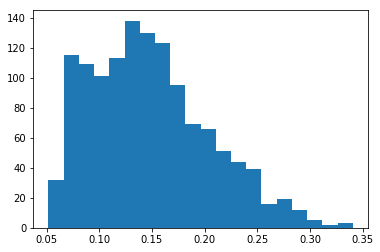

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(sprinkled_lc_obs_withtruth.query("uniqueId==338704312844405")['flux'].values, bins=20)

In [5]:


# To estimate mag_err,
# As in p.5 of the TDC1 Results paper
# 1. Find mean, std of the fiveSigmaDepth in nMgy
df['obs_metadata']['sigma'] = units.mag_to_flux(df['obs_metadata']['fiveSigmaDepth'], to_unit='nMgy')
sigma_nmgy = df['obs_metadata']['sigma'].values
sigma_mean = np.mean(sigma_nmgy)
sigma_std = np.std(sigma_nmgy)

# 2. Get 0.2*mean, 0.2*std from #1
noise_mean = sigma_mean*0.2
noise_std = sigma_std*0.2
print(noise_mean, noise_std)

# 3. Sample from N(0.2*mean, 0.2*std)
noise = pd_utils.gaussian_noise(mean=noise_mean, stdev=noise_std, shape=sprinkled_lc_obs_withtruth.shape[0])
sprinkled_lc_obs_withtruth['flux_err'] = pd_utils.gaussian_noise(mean=noise_mean, stdev=noise_std, shape=sprinkled_lc_obs_withtruth.shape[0])
sprinkled_lc_obs_withtruth.loc[sprinkled_lc_obs_withtruth['flux_err']< 0.001, 'flux_err'] = 0.001

sprinkled_lc_obs_withtruth['mag_err'] = np.abs((2.5/np.log(10.0))*sprinkled_lc_obs_withtruth['flux_err']/sprinkled_lc_obs_withtruth['flux'])

0.1118200931107296 0.08200784327050017


(array([   4.,   13.,   33.,   78.,  231.,  412.,  772., 1044., 1388.,
        1486., 1424., 1186.,  924.,  624.,  359.,  165.,   70.,   33.,
           7.,    3.]),
 array([-0.18596474, -0.15563784, -0.12531095, -0.09498405, -0.06465715,
        -0.03433025, -0.00400335,  0.02632355,  0.05665044,  0.08697734,
         0.11730424,  0.14763114,  0.17795804,  0.20828494,  0.23861184,
         0.26893873,  0.29926563,  0.32959253,  0.35991943,  0.39024633,
         0.42057323]),
 <a list of 20 Patch objects>)

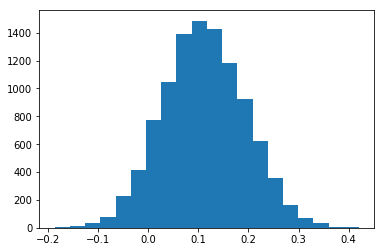

In [6]:
plt.hist(noise, bins=20)
#plt.hist(sprinkled_lc_obs_withtruth['flux_err'], bins=20)

In [7]:
per_filter_mean = sprinkled_lc_obs_withtruth.groupby(['uniqueId', 'filter'], as_index=False)['flux'].mean().copy()
per_filter_mean.rename(columns={'flux': 'flux_perband_avg'}, inplace=True)
sprinkled_lc_obs_withtruth = pd.merge(sprinkled_lc_obs_withtruth, per_filter_mean, on=['uniqueId', 'filter'])

In [8]:
per_lc_mean = sprinkled_lc_obs_withtruth.groupby('uniqueId', as_index=False)['flux'].mean().copy()
per_lc_mean.rename(columns={'flux': 'flux_overall_avg'}, inplace=True)
sprinkled_lc_obs_withtruth = pd.merge(sprinkled_lc_obs_withtruth, per_lc_mean, on='uniqueId')

In [9]:
#joined_with_avg.head(100)
sprinkled_lc_obs_withtruth.set_index('uniqueId', inplace=True)
sprinkled_lc_obs_withtruth['whitening_offset'] = sprinkled_lc_obs_withtruth['flux_perband_avg'].copy() - sprinkled_lc_obs_withtruth['flux_overall_avg'].copy()
sprinkled_lc_obs_withtruth['flux'] -= sprinkled_lc_obs_withtruth['whitening_offset']
#sprinkled_lc_obs_withtruth.loc[sprinkled_lc_obs_withtruth['flux'] < 0.0, 'flux'] = 0.0
sprinkled_lc_obs_withtruth.reset_index(inplace=True)

In [10]:
sprinkled_lc_obs_withtruth['flux'].values.min()

-0.002671658939787024

In [11]:
# Final conversion to mag (since we altered flux)
sprinkled_lc_obs_withtruth['mag'] = units.flux_to_mag(sprinkled_lc_obs_withtruth['flux'], from_unit='nMgy')

utils/units_utils.py:16: RuntimeWarning: invalid value encountered in log10
  return zeropoint_mag-2.5*np.log10(flux)


In [12]:
sprinkled_lc_obs_withtruth.to_csv("joined_sprinkled.csv", index=False)

In [13]:
sprinkled_lc_obs_withtruth.head()

,uniqueId,obshistid,mag,galaxy_id,ra,dec,redshift,truth_galaxy_id,truth_redshift,magNorm,agn_tau,t0Delay,agn_sfu,agn_sfg,agn_sfr,agn_sfi,agn_sfz,agn_sfy,mjd,filter,fiveSigmaDepth,flux,flux_err,mag_err,flux_perband_avg,flux_overall_avg,whitening_offset
0,338704312844405,230,24.798160,33076593,53.051657,-28.086531,0.62,330765930512,0.62,24.646572,153.8,0.0,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59580.139555,r,24.083783,0.120430,0.001000,0.011799,0.119958,0.148366,-0.028408
1,338704312844405,181866,24.817073,33076593,53.051657,-28.086531,0.62,330765930512,0.62,24.646572,153.8,0.0,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.274782,r,24.149110,0.118351,0.137145,1.655530,0.119958,0.148366,-0.028408
2,338704312844405,181898,24.817111,33076593,53.051657,-28.086531,0.62,330765930512,0.62,24.646572,153.8,0.0,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.289313,r,24.100863,0.118347,0.068321,0.824771,0.119958,0.148366,-0.028408
3,338704312844405,181900,24.817113,33076593,53.051657,-28.086531,0.62,330765930512,0.62,24.646572,153.8,0.0,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.290208,r,24.081562,0.118346,0.109661,1.323825,0.119958,0.148366,-0.028408
4,338704312844405,181970,24.817197,33076593,53.051657,-28.086531,0.62,330765930512,0.62,24.646572,153.8,0.0,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.322524,r,24.036042,0.118337,0.057097,0.689346,0.119958,0.148366,-0.028408
